In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("rstan")

In [ ]:
%%R
library("rstan")

## Advanced

## Assumption here is that NOT all `guideID`s are functional

In [ ]:
%%R
# Load data
data <- read.csv("./data1.txt", header = T, sep = '\t')

for (gene in unique(data$geneID)[1:2]){
  cat("*******************************\n")
  cat("Working with gene: ", gene, '\n')
  cat("*******************************\n")

  # Subset
  dat <- data[data$geneID == gene,]
  print(nrow(dat))

  # Create a binary indicator for control samples (1 if enhancerID or guideID == -1, 0 otherwise)
  dat$is_control <- ifelse(dat$enhancerID == -1 | dat$guideID == -1, 1, 0)

  ## Indicate control data
  y_control <- dat[dat$is_control == 1,]$expression
  y_experiment <- dat[dat$is_control == 0,]$expression

  # Make sure we have the variables factored, then converted to integer representations
  for (nm in colnames(dat)[colnames(dat) != "expression"]) dat[[nm]] <- as.integer(as.factor(dat[[nm]]))

  # Prepare data for Stan
  stan_data <- list(
    N = nrow(dat),
    X = dat$expression,
    gene = dat$geneID,
    enhancer = dat$enhancerID,
    guideID = dat$guideID,
    G = length(unique(dat$guideID)),  # Number of unique guides
    E = length(unique(dat$enhancerID)),
    NGENE = length(unique(dat$geneID)),
    is_control = dat$is_control,
    y_control = y_control,
    NCONTROL = length(y_control),
    NEXPERIMENT = length(y_experiment),
    y_experiment = y_experiment
  )

  stan_code <- "
  data {
    int<lower=0> NCONTROL;                 // Number of control samples
    int<lower=0> NEXPERIMENT;              // Number of experiment samples
    int<lower=0> N;                     // Total number of observations
    int<lower=1> G;                     // Number of unique guides
    int<lower=1> E;                     // Number of unique enhancers
    real<lower=0> X[N];                 // Expression counts
    int<lower=1,upper=G> guideID[N];    // GuideID for each observation
    int<lower=1,upper=E> enhancer[N];   // EnhancerID for each observation
    int<lower=0> is_control[N];         // Control indicator (1=control, 2=experiment)
    int<lower=0> y_control[NCONTROL];             // Control samples
    int<lower=0> y_experiment[NEXPERIMENT];          // Experiment samples
  }

  transformed data {
    real<lower=0> mu_control_observed = mean(y_control);            // Empirical mean of y_control
    real<lower=0> sigma_control_observed = sd(y_control);           // Empirical standard deviation of y_control
    real<lower=0> mu_experiment_observed = mean(y_experiment);      // Empirical mean of y_experiment
    real<lower=0> sigma_experiment_observed = sd(y_experiment);     // Empirical standard deviation of y_experiment
    real beta_observed = mu_experiment_observed / mu_control_observed;  // Empirical effect size
  }

  parameters {
    real<lower=0,upper=1> r;            // Mixture probability for experimental component
    vector<lower=0,upper=1>[E] beta;    // Beta coefficients for enhancers
    real mu_experimental;            // Means for the experimental component by guideID
    real<lower=0> sigma_experimental;   // Shared experimental component standard deviation
    real mu_control[G];                    // Mean for the control component
    real<lower=0> sigma_control;        // Control standard deviation
  }

  model {
    // Priors
    r ~ beta(2, 2);                     // Beta Prior for r
    beta ~ beta(2, 2);                  // Priors for beta coefficients
    mu_experimental ~ normal(mu_experiment_observed, sigma_experiment_observed);    // Priors for experimental means
    sigma_experimental ~ inv_gamma(1, 1); // Prior for experimental standard deviation
    mu_control ~ normal(mu_control_observed, sigma_control_observed);         // Prior for control mean
    sigma_control ~ inv_gamma(1, 1);    // Prior for control standard deviation

    // Likelihood
    for (i in 1:N) {
      if (is_control[i] == 2) {
        // Control samples follow the control distribution
        X[i] ~ normal(mu_control, sigma_control);
      } else {
        // Experimental samples are a mixture
        target += log_sum_exp(
          log(r) + normal_lpdf(X[i] | mu_control[guideID[i]] * beta[enhancer[i]], sigma_experimental),
          log(1 - r) + normal_lpdf(X[i] | mu_control, sigma_control)
        );
      }
    }
  }

  generated quantities {
    real X_pred[N];                     // Predicted expression for each observation
    for (i in 1:N) {
      if (is_control[i] == 2) {
        // Predict from control distribution for control samples
        X_pred[i] = normal_rng(mu_control[guideID[i]], sigma_control);
      } else {
        // Predict from mixture for experimental samples
        if (bernoulli_rng(r) == 1) {
          X_pred[i] = normal_rng(mu_control[guideID[i]] * beta[enhancer[i]], sigma_experimental);
        } else {
          X_pred[i] = normal_rng(mu_control[guideID[i]], sigma_control);
        }
      }
    }
  }
  "

  # Compile and fit the model
  fit <- stan(
    model_code = stan_code,
    data = stan_data,
    iter = 100,
    seed = 1337,
    warmup = 25,
    chains = 4,
    #diagnostic_file = "FINAL_diagnostics.csv"
  )
  saveRDS(fit, file = paste("./results/FINAL_",gene,"_fit.rds", sep = ''))
}



*******************************
Working with gene:  1 
*******************************
[1] 780

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000789 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.89 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: WARNING: There aren't enough warmup iterations to fit the
Chain 1:          three stages of adaptation as currently configured.
Chain 1:          Reducing each adaptation stage to 15%/75%/10% of
Chain 1:          the given number of warmup iterations:
Chain 1:            init_buffer = 3
Chain 1:            adapt_window = 20
Chain 1:            term_buffer = 2
Chain 1: 
Chain 1: Iteration:  1 / 100 [  1%]  (Warmup)
Chain 1: Iteration: 10 / 100 [ 10%]  (Warmup)
Chain 1: Iteration: 20 / 100 [ 20%]  (Warmup)
Chain 1: Iteration: 26 / 100 [ 26%]  (Sampling)
Chain 1: Iteration: 35 / 100 [ 35%]  (Sampling)
Chain 1: Iteration: 45 /

Note that we estimate the beta coefficients by way of:

$$X_i ~ \beta_{i} \mu_{\text{control}_{i}}$$

For all $i \in 1...N$

Then, when we predict expression, we do so using these values. As a result, we only use the experimental values for inferring the beta coefficients, after which we no longer use them.

In [ ]:
%%R
# Summary statistics for beta coefficients
print(fit, pars = c("beta"), probs = c(0.025, 0.5, 0.975))

Inference for Stan model: anon_model.
4 chains, each with iter=100; warmup=25; thin=1; 
post-warmup draws per chain=75, total post-warmup draws=300.

        mean se_mean   sd 2.5%  50% 97.5% n_eff Rhat
beta[1] 0.37    0.11 0.22 0.04 0.39  0.75     4 1.80
beta[2] 0.43    0.14 0.26 0.02 0.39  0.84     3 2.04
beta[3] 0.46    0.08 0.22 0.11 0.50  0.84     8 1.65
beta[4] 0.41    0.05 0.17 0.12 0.40  0.74    10 1.33
beta[5] 0.45    0.10 0.24 0.13 0.37  0.88     5 1.86
beta[6] 0.48    0.12 0.21 0.13 0.45  0.85     3 2.03

Samples were drawn using NUTS(diag_e) at Sat Nov 23 18:44:23 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


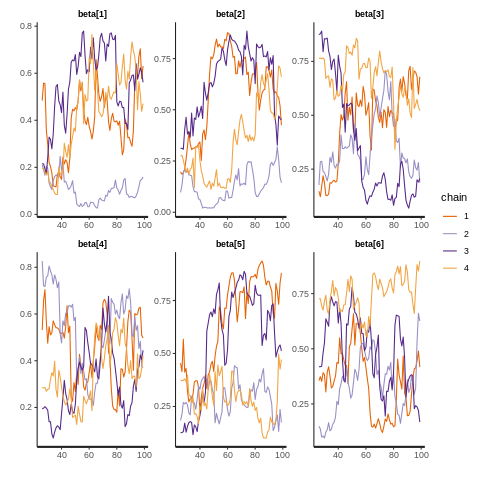

In [ ]:
%%R
traceplot(fit, pars = c("beta"))

In [ ]:
%%R
check_hmc_diagnostics(fit)


Divergences:



Tree depth:


Try increasing 'max_treedepth' to avoid saturation.




Energy:


  Chain 4: E-BFMI = 0.159
E-BFMI below 0.2 indicates you may need to reparameterize your model.



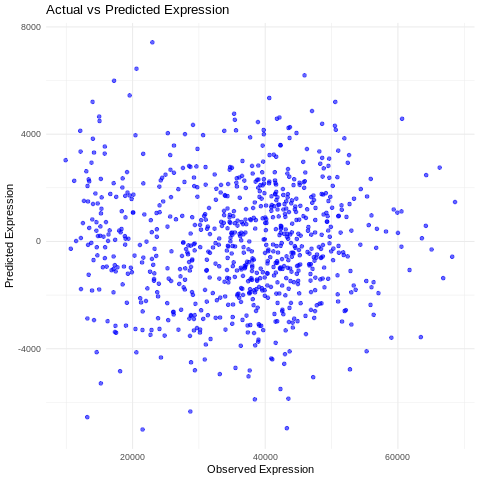

In [ ]:
%%R
# Extract predicted samples (posterior predictive)
posterior_predictive <- extract(fit, pars = "X_pred")$X_pred

# Compute the mean of posterior predictive samples for each observation
predicted_mean <- apply(posterior_predictive, 2, mean)

plot_data <- data.frame(
  observed = dat$expression,
  predicted = predicted_mean
)

library(ggplot2)

ggplot(plot_data, aes(x = observed, y = predicted)) +
  geom_point(color = "blue", alpha = 0.6) +
  labs(
    title = "Actual vs Predicted Expression",
    x = "Observed Expression",
    y = "Predicted Expression"
  ) +
  theme_minimal()

In [ ]:
%%R
dat$predicted <- predicted_mean
head(dat, 75)

    geneID enhancerID guideID cellID expression is_control  predicted
781      1          1       1      1      47803          2  -485.4606
782      1          1       1      2      39385          2 -3144.6783
783      1          1       1      3      42603          2 -1021.0432
784      1          1       1      4      46907          2 -1888.1314
785      1          1       1      5      40343          2 -1199.4833
786      1          1       1      6      47232          2 -5061.3555
787      1          1       1      7      36965          2  -961.3581
788      1          1       1      8      48484          2 -2307.6328
789      1          1       1      9      63456          2 -3566.2131
790      1          1       1     10      56727          2  -238.7025
791      1          1       1     11      37416          2 -1483.6879
792      1          1       1     12      44876          2 -2973.7688
793      1          1       1     13      46283          2  3447.3402
794      1          

In [ ]:
%%R
# Extract the posterior samples for beta
beta_samples <- extract(fit, pars = "beta")$beta

beta_mean <- apply(beta_samples, 2, mean)

beta_df <- data.frame(
  enhancerID = 1:length(beta_mean),  # Enhancer IDs (assuming 1-based indexing in Stan)
  beta_mean = beta_mean
)

# Merge beta coefficients with the original dataset
dat_beta <- merge(dat, beta_df, by.x = "enhancerID", by.y = "enhancerID", all.x = TRUE)

true_betas <- read.csv("./true-betas1.txt", header = T, sep = '\t')

results <- merge(dat_beta, true_betas, by = c("geneID", "enhancerID"), all.x = TRUE)
# Subset what we need
results <- results[,c("geneID", "enhancerID", "beta_mean", "beta")]
# Drop duplicate observations
results <- results[!duplicated(results),]

In [ ]:
%%R
head(results, 35)

    geneID enhancerID beta_mean beta
1        1          1 0.3719561 0.88
31       1          2 0.4261465 0.59
181      1          3 0.4642499 0.39
331      1          4 0.4117844 0.70
481      1          5 0.4464377 0.32
631      1          6 0.4823575   NA


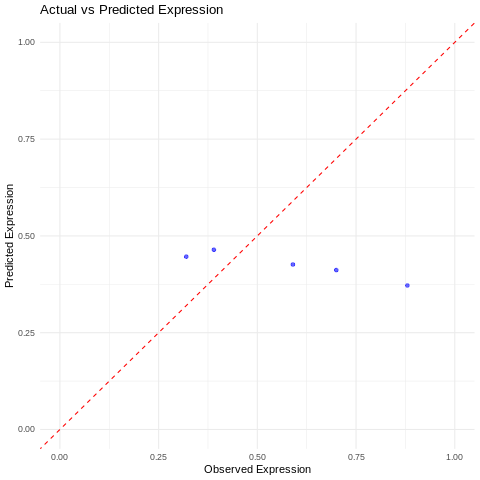

In [ ]:
%%R
ggplot(results, aes(x = beta, y = beta_mean)) +
  geom_point(color = "blue", alpha = 0.6) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  labs(
    title = "Actual vs Predicted Expression",
    x = "Observed Expression",
    y = "Predicted Expression"
  ) +
  theme_minimal() + ylim(c(0, 1)) + xlim(c(0, 1))

In [ ]:
%%R
# Remove NAs
results <- na.omit(results)

# Mean Squared Error
mse <- mean((results$beta - results$beta_mean)^2)

# Mean Absolute Error
mae <- mean(abs(results$beta - results$beta_mean))

cat("Mean Squared Error (MSE):", mse, "\n")
cat("Mean Absolute Error (MAE):", mae, "\n")

Mean Squared Error (MSE): 0.07790488 
Mean Absolute Error (MAE): 0.2321601 
